In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm 
import seaborn as sns
import theano

sns.set_style('whitegrid')
np.random.seed(123)

data = pd.read_csv('radon.csv')
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_index = data.county_code.values

n_counties = len(data.county.unique())

In [5]:
with pm.Model() as hierarchical_model_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)

    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    # Linear regression
    radon_est = a[county_index] + b[county_index] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [6]:
with hierarchical_model_centered:
    hierarchical_centered_trace = pm.sample(draws=5000, tune=1000, njobs=4)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1,102.9:  11%|█▏        | 22956/200000 [00:06<00:45, 3869.47it/s]
Convergence archived at 23200
Interrupted at 23,200 [11%]: Average Loss = 1,434.1
 67%|██████▋   | 3998/6000 [00:43<00:16, 119.71it/s]/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6000/6000 [01:02<00:00, 95.61it/s] 
/home/thomas/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 3 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


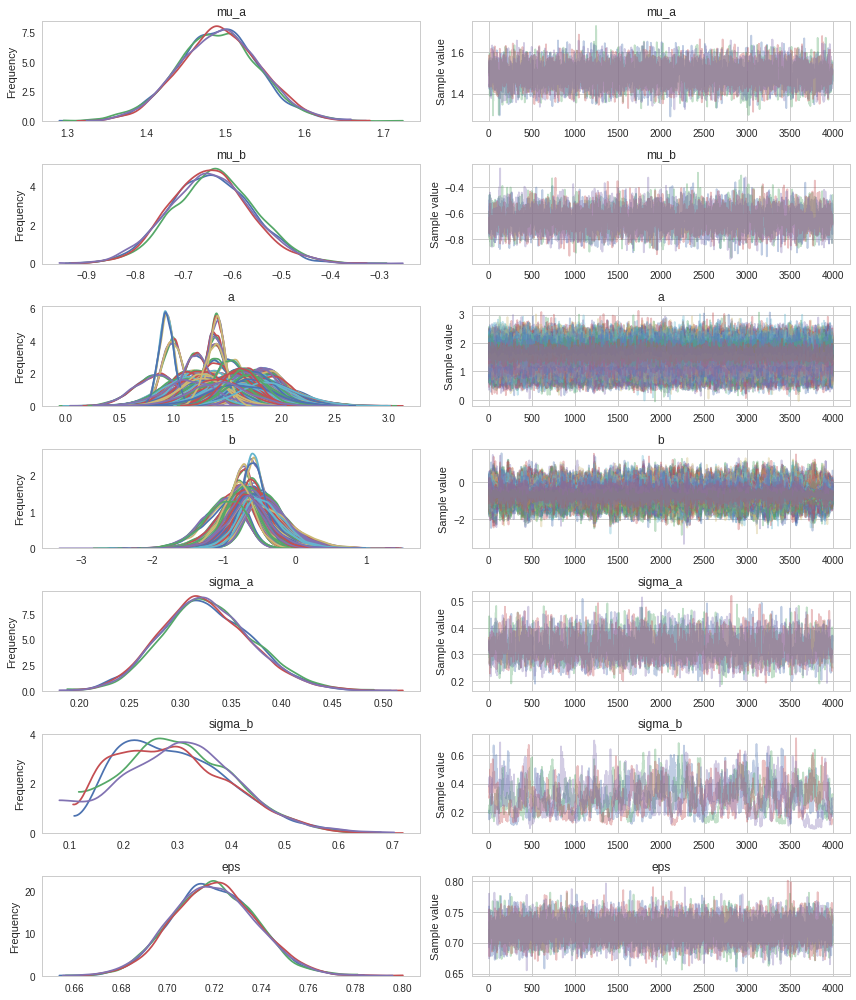

In [7]:
pm.traceplot(hierarchical_centered_trace);

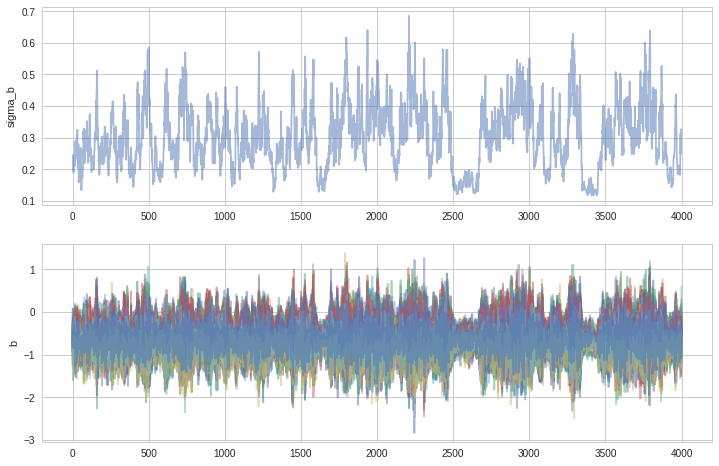

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 8))
axs[0].plot(hierarchical_centered_trace.get_values('sigma_b', chains=1), alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(hierarchical_centered_trace.get_values('b', chains=1), alpha=.5);
axs[1].set(ylabel='b');

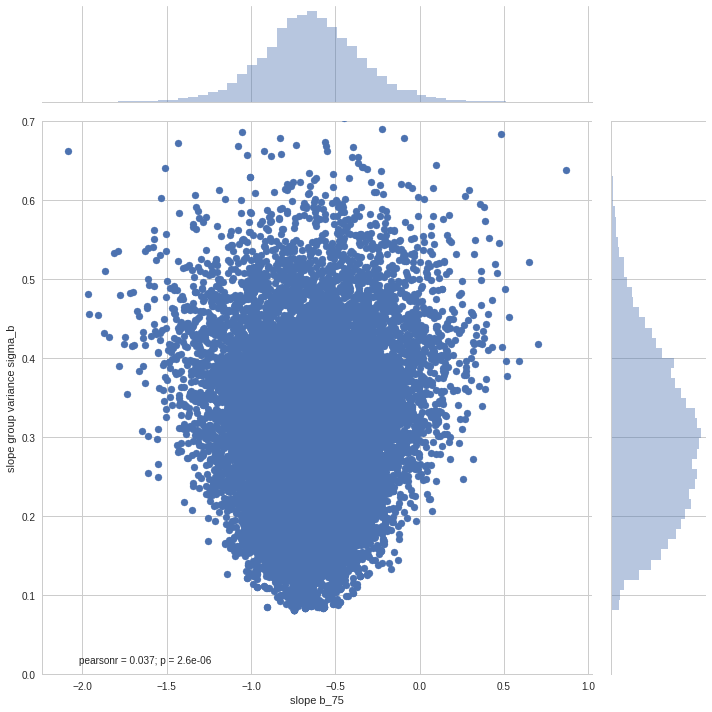

In [14]:
x = pd.Series(hierarchical_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_centered_trace['sigma_b'], name='slope group variance sigma_b')

sns.jointplot(x, y, ylim=(0, .7), size=10);

In [15]:
with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [16]:
with hierarchical_model_non_centered:
    hierarchical_non_centered_trace = pm.sample(draws=5000, tune=1000, njobs=4)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1,085.7:  12%|█▏        | 23869/200000 [00:06<00:45, 3910.30it/s]
Convergence archived at 23900
Interrupted at 23,900 [11%]: Average Loss = 1,546.1
100%|██████████| 6000/6000 [02:09<00:00, 46.38it/s] 


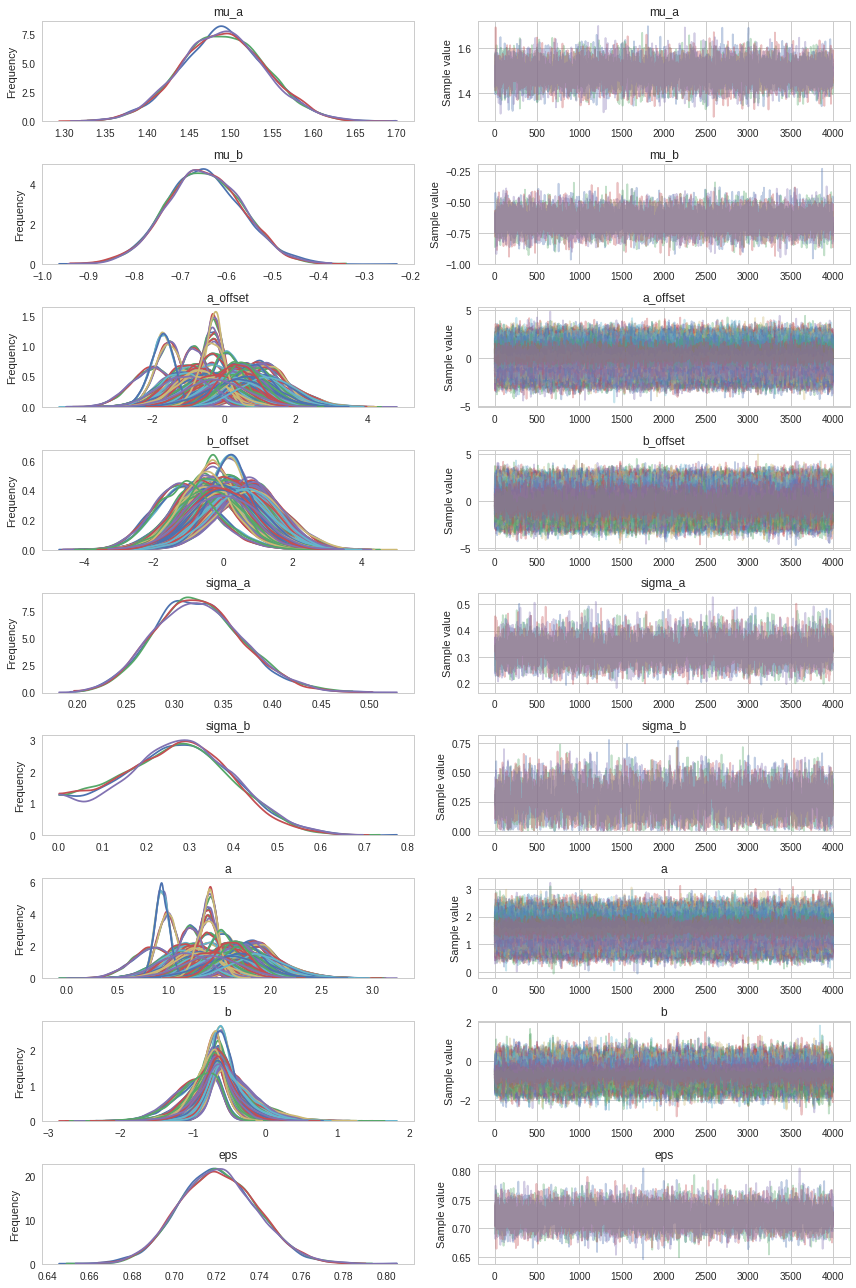

In [17]:
pm.traceplot(hierarchical_non_centered_trace);

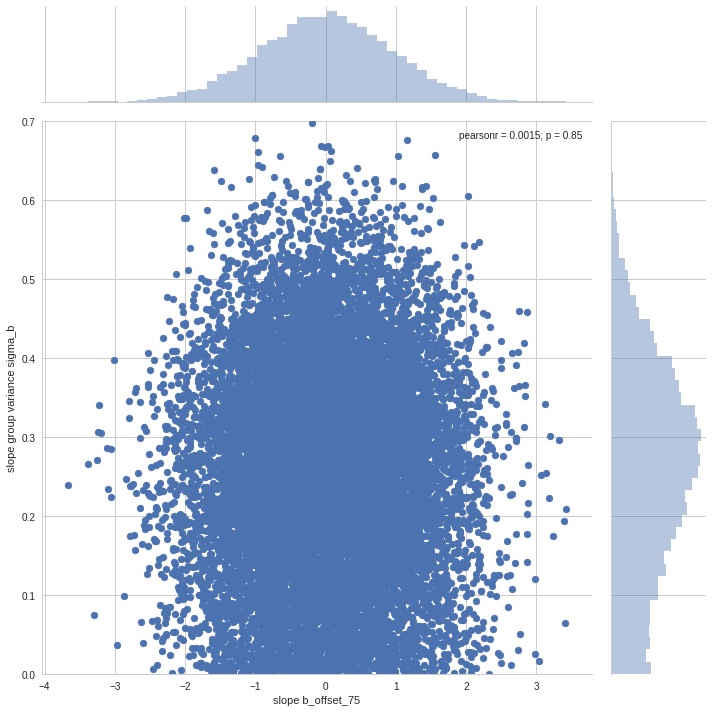

In [19]:
x = pd.Series(hierarchical_non_centered_trace['b_offset'][:, 75], name='slope b_offset_75')
y = pd.Series(hierarchical_non_centered_trace['sigma_b'], name='slope group variance sigma_b')

sns.jointplot(x, y, ylim=(0, .7), size=10);

In [22]:
%load_ext watermark
%watermark -dmvgp numpy,scipy,pandas,matplotlib,seaborn,patsy,pymc3,theano,joblib

2017-08-27 

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.20.1
matplotlib 2.0.2
seaborn 0.7.1
patsy 0.4.1
pymc3 3.1
theano 0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
joblib 0.11

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   :
